In [1]:
%load_ext autoreload
%autoreload 2

> **How to run this notebook (command-line)?**
1. Install the `ReinventCommunity` environment:
`conda env create -f environment.yml`
2. Activate the environment:
`conda activate ReinventCommunity`
3. Execute `jupyter`:
`jupyter notebook`
4. Copy the link to a browser


# `REINVENT` score transformation notebook
This notebook serves two purposes: **(a)** to explain, what is meant by *score transformation*  in the context of `REINVENT` and how to use it and **(b)** to serve as a way to find the proper transfomation parameters for a new or updated component.

### Background
As described in the Reinforcement Learning notebook in this repository, `REINVENT` uses different components in its scoring functions, which can be freely combined to generate a composite score for a compound. Each component returns a partial score between '0' and '1' and a selected functional form (either a product or a sum) produces the final composite score (again, a number between '0' and '1'). The following lines are an excerpt of an actual run that illustrates this:

```
INFO     
Step 0   Fraction valid SMILES: 99.2   Score: 0.1583   Time elapsed: 0   Time left: 0.0
 Agent     Prior     Target     Score     SMILES
-29.25    -29.25     -0.60      0.22      n1c(CN2CCOCC2)cnc2[nH]c3c(cc(C)c(C)c3)c12
-27.63    -27.63    -27.63      0.00      C1N(Cc2ccccc2)C(=O)c2cccc(N3C(=O)c4ccc(C(O)=O)cc4C3=O)c2C1
-40.76    -40.76    -14.11      0.21      C(NC(c1csnn1)=O)(c1ccc(-c2cc(Cl)cc(F)c2-c2nnn(C)n2)o1)(C)CC

Regression model   Matching substructure   Custom alerts   QED Score
0.3370678424835205          0.5                  1.0        0.78943
0.3446018993854522          1.0                  0.0        0.64563
0.3945346176624298          0.5                  1.0        0.46391
```

Each component (e.g. the `QED Score`) produces a partial score which is combined into `Score` (see product functional below).

![](img/scoring_function_product.png)

For this to work, we need to ensure, that all components return a meaningful value from the interval [0,1], on top of which values closer to '1' must mean "better" as we are always trying to maximize the composite score. However, most components will not naturally comply with this requirements. In those cases, we can define a transformation (effectively the application of a mathematical function with given parameters) to the "raw" score returned by the component before feeding it into the scoring function.

First, let's load up everything we need:

In [2]:
# load the dependencies and classes used
%run code/score_transformation_code.py

# set plotting parameters
small = 12
med = 16
large = 22
params = {"axes.titlesize": large,
          "legend.fontsize": med,
          "figure.figsize": (16, 10),
          "axes.labelsize": med,
          "axes.titlesize": med,
          "xtick.labelsize": med,
          "ytick.labelsize": med,
          "figure.titlesize": large}
plt.rcParams.update(params)
plt.style.use("seaborn-whitegrid")
sns.set_style("white")
%matplotlib inline

# set up Enums and factory
tt_enum = TransformationTypeEnum()
csp_enum = ComponentSpecificParametersEnum()
factory = TransformationFactory()

### Example
The following example simulates the incorporation of a new (fictious) component. Let us assume, we have run 10 compounds through this component and got the following values:

```
-12.4, -9.0, 1.3, 2.3, 0.7, -4.2, -0.3, -7.7, -9.9, 3.3
```

From your experience, you do consider a value above 0.3 to be very interesting and anything below -3 as completely useless. Thus we will choose a `sigmoid` transformation and adapt the parameters to reflect that. To get a nice curve in a plot which helps us deciding whether we are on the right track, we will define a range of values from -10 to 5 in a list.

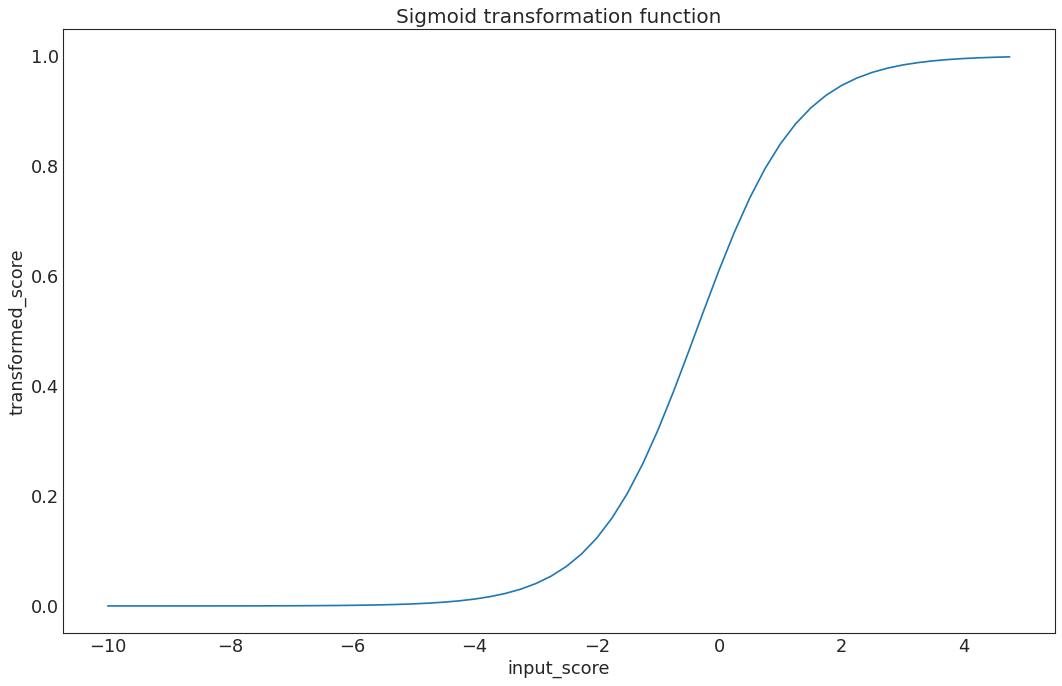

In [3]:
# specify a list of dummy input values
values_list = np.arange(-10, 5, 0.25).tolist()

# set up the parameters
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: -2,
                       csp_enum.HIGH: 1.25,
                       csp_enum.K: 0.17,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.SIGMOID}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title="Sigmoid transformation function", x=values_list, y=transformed_scores)

In [4]:
# check, whether the transformation does what we expect
input_values = [-12.4, -9.0, 1.3, 2.3, 0.7, -4.2, -0.3, -7.7, -9.9, 3.3]
output_values = transform_function(predictions=input_values,
                                   parameters=specific_parameters)
print(input_values)
print([round(x, 1) for x in output_values])

[-12.4, -9.0, 1.3, 2.3, 0.7, -4.2, -0.3, -7.7, -9.9, 3.3]
[0.0, 0.0, 0.9, 1.0, 0.8, 0.0, 0.5, 0.0, 0.0, 1.0]


As you can see, we have found a transformation that satisfies our needs in this case. It is important, that there is a smooth transition (so do not set parameter `K` to very high values), so that the "trail" can be picked up. You can play around with the parameters to see the effect on the curve and the output values. The parameters can be directly set in the `REINVENT` configuration file.

### All transformations
Of course, sometimes you will need other transformations than a `sigmoid` one, so below is a complete list of all transformations available at the moment.

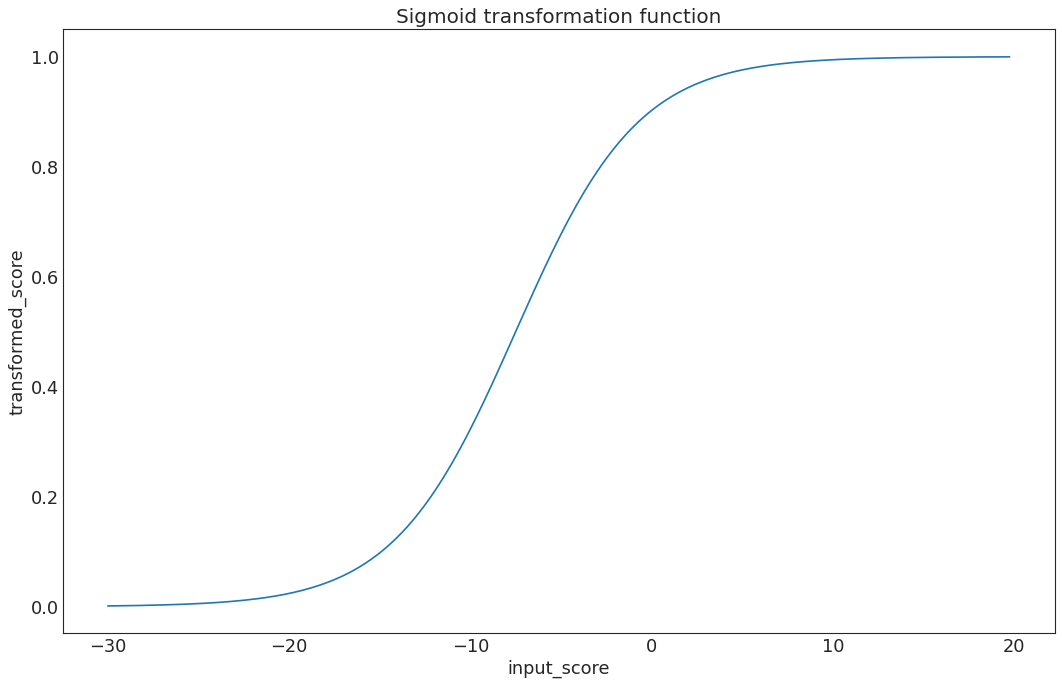

In [5]:
# sigmoid transformation
# ---------
values_list = np.arange(-30, 20, 0.25).tolist()
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: -25,
                       csp_enum.HIGH: 10,
                       csp_enum.K: 0.4505,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.SIGMOID}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title="Sigmoid transformation function", x=values_list, y=transformed_scores)

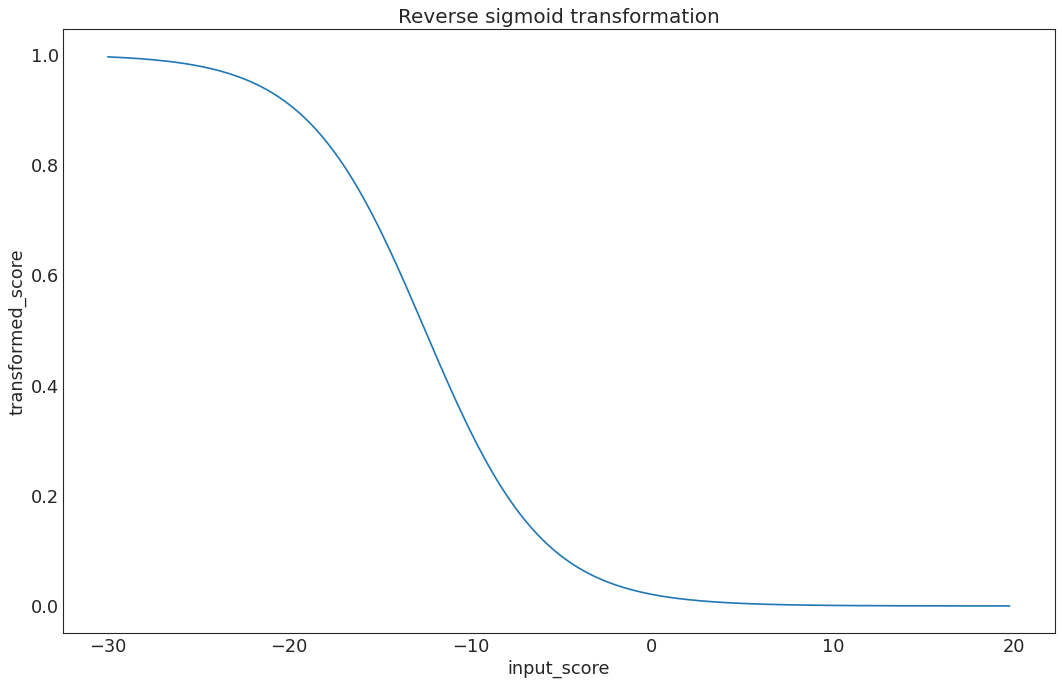

In [6]:
# reverse sigmoid transformation
# ---------
values_list = np.arange(-30, 20, 0.25).tolist()
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: -20,
                       csp_enum.HIGH: -5,
                       csp_enum.K: 0.2,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.REVERSE_SIGMOID}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title="Reverse sigmoid transformation", x=values_list, y=transformed_scores)

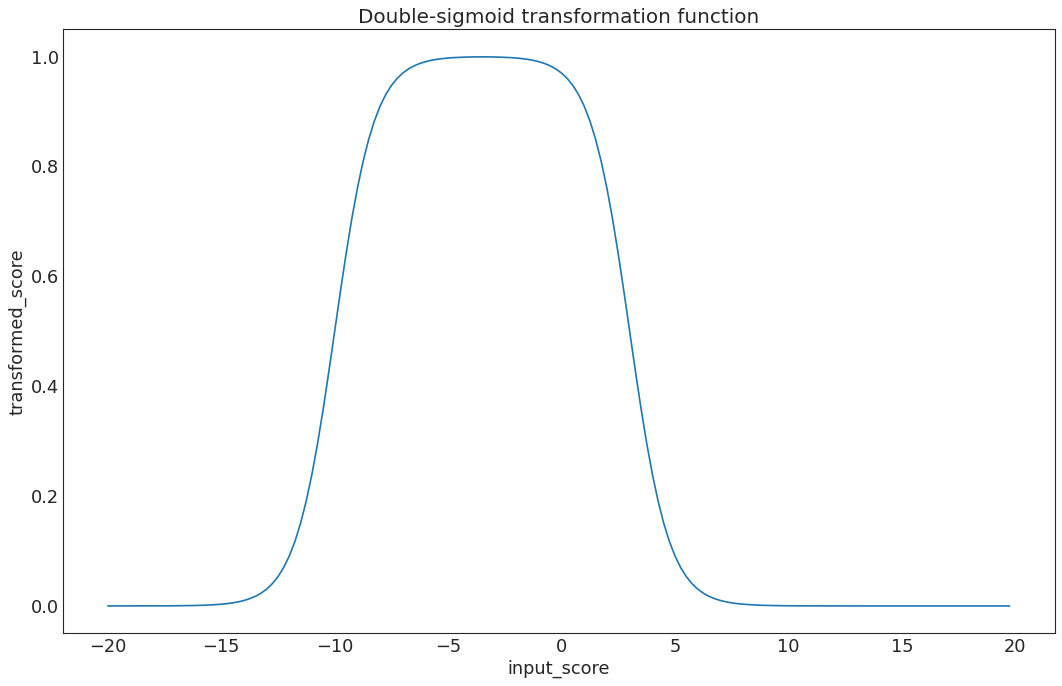

In [7]:
# double sigmoid
# ---------
values_list = np.arange(-20, 20, 0.25).tolist()
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: -10,
                       csp_enum.HIGH: 3,
                       csp_enum.COEF_DIV: 500,
                       csp_enum.COEF_SI: 250,
                       csp_enum.COEF_SE: 250,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.DOUBLE_SIGMOID}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title="Double-sigmoid transformation function", x=values_list, y=transformed_scores)

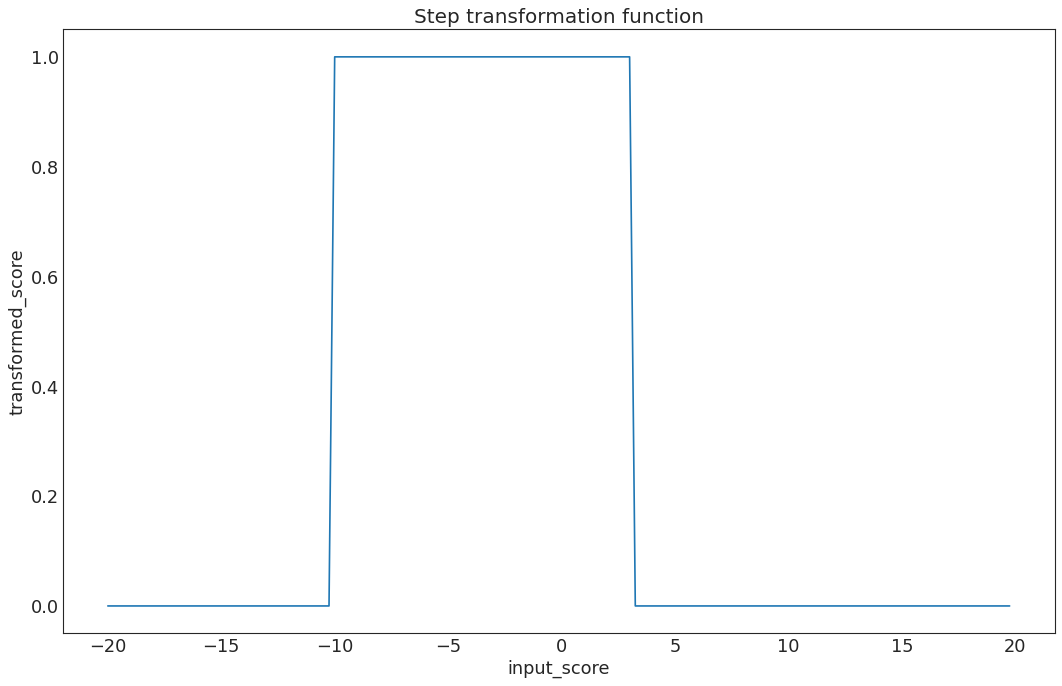

In [8]:
# step
# ---------
values_list = np.arange(-20, 20, 0.25).tolist()
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: -10,
                       csp_enum.HIGH: 3,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.STEP}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title="Step transformation function", x=values_list, y=transformed_scores)

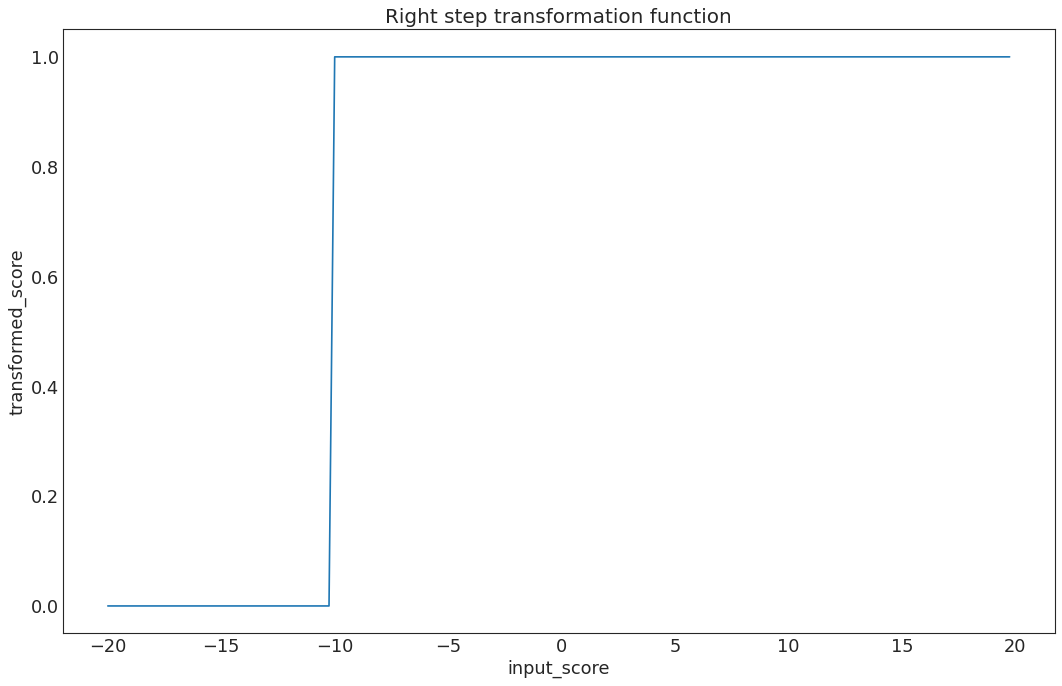

In [9]:
# right step
# ---------
values_list = np.arange(-20, 20, 0.25).tolist()
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: -10,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.RIGHT_STEP}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title="Right step transformation function", x=values_list, y=transformed_scores)

There is also a `no_transformation` type, which does not change the input values at all.